# Three Layer NN Without Dropout

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm

In [3]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,-0.600793,-0.611672,-0.641927,-0.703334,-0.735307,-0.768693,-0.800064,-0.804619,-0.820434,-0.815434,...,-0.569687,-0.576000,-0.578024,-0.579432,-0.603702,-0.614348,-0.570614,-0.585905,tuberculosis,3
1,1.984041,1.983801,1.959033,1.940365,1.935875,1.934162,1.937535,1.936295,1.967151,2.081924,...,1.174397,1.282001,1.260898,1.246758,1.227232,1.154427,0.827348,0.846903,dengue,0
2,-0.309623,-0.758681,0.316584,0.492371,0.592256,0.721028,0.737815,0.895757,0.929506,0.289527,...,1.541171,1.465912,1.593909,1.872238,1.414773,2.063128,2.243709,2.291239,dengue,0
3,-0.220918,-0.047667,-0.062442,-0.109892,-0.299183,-0.309485,-0.330068,-0.316008,-0.307686,-0.289970,...,-0.029082,-0.028372,-0.036696,-0.027367,-0.038670,-0.053340,-1.094856,-1.105207,dengue,0
4,1.532853,1.535051,1.503432,1.482185,1.478143,1.476522,1.479842,1.484116,1.502529,1.549556,...,1.377466,1.370742,1.358552,1.363322,1.349046,1.286549,1.269561,1.241234,tuberculosis,3


In [7]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [9]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.dense1 = nn.Linear(1440, 1024)
    self.dense2 = nn.Linear(1024, 512)
    self.dense3 = nn.Linear(512, 64)
    self.dense4 = nn.Linear(64, 4)

    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.to(DEVICE)

    x = self.relu(self.dense1(x))
    x = self.relu(self.dense2(x))
    x = self.relu(self.dense3(x))

    return self.softmax(self.dense4(x))

In [12]:
sample_x, sample_y = next(iter(train_loader))

## SGD

In [13]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (dense1): Linear(in_features=1440, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=512, bias=True)
  (dense3): Linear(in_features=512, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [14]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Linear: 1-1                            [8, 1024]                 1,475,584
├─ReLU: 1-2                              [8, 1024]                 --
├─Linear: 1-3                            [8, 512]                  524,800
├─ReLU: 1-4                              [8, 512]                  --
├─Linear: 1-5                            [8, 64]                   32,832
├─ReLU: 1-6                              [8, 64]                   --
├─Linear: 1-7                            [8, 4]                    260
├─Softmax: 1-8                           [8, 4]                    --
Total params: 2,033,476
Trainable params: 2,033,476
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 16.27
Input size (MB): 0.05
Forward/backward pass size (MB): 0.10
Params size (MB): 8.13
Estimated Total Size (MB): 8.28

In [15]:
tb_board = RUNS_PATH + "three_layer_nn_without_dropout_sgd"
writer = SummaryWriter(tb_board)

In [16]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [18]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3866869688034058 - Accuracy: 0.30434782608695654 - Precision: 0.09262759924385633 - Recall: 0.30434782608695654 - F1: 0.14202898550724638
Epoch: 2 - Loss: 1.3861448685328166 - Accuracy: 0.3130434782608696 - Precision: 0.22035398230088496 - Recall: 0.3130434782608696 - F1: 0.16021758083469162
Epoch: 3 - Loss: 1.385409688949585 - Accuracy: 0.3217391304347826 - Precision: 0.2632246376811594 - Recall: 0.3217391304347826 - F1: 0.17644927536231883
Epoch: 4 - Loss: 1.384114940961202 - Accuracy: 0.3217391304347826 - Precision: 0.22205248726987858 - Recall: 0.3217391304347826 - F1: 0.17648672550399772
Epoch: 5 - Loss: 1.3825585921605428 - Accuracy: 0.3391304347826087 - Precision: 0.2658423082036963 - Recall: 0.3391304347826087 - F1: 0.20558661145617668
Epoch: 6 - Loss: 1.3824884414672851 - Accuracy: 0.3652173913043478 - Precision: 0.250520613479668 - Recall: 0.3652173913043478 - F1: 0.24048749750257425
Epoch: 7 - Loss: 1.3810170968373616 - Accuracy: 0.3652173913043478 - Preci

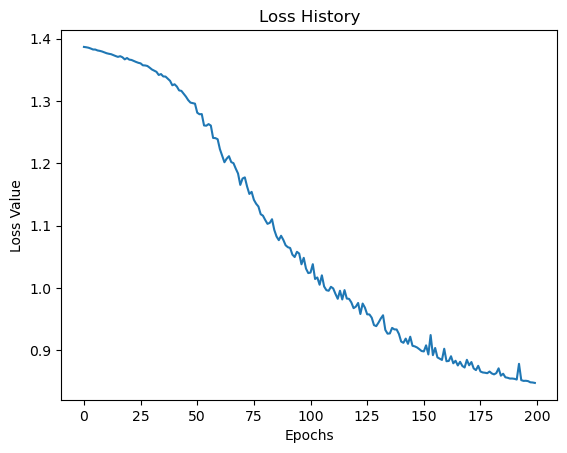

In [19]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/train_loss_history_three_layer_nn_without_dropout_sgd.pdf", bbox_inches="tight")
plt.show()

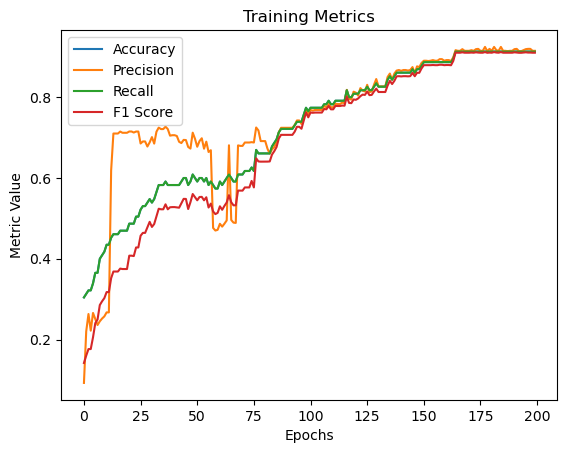

In [20]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_three_layer_nn_without_dropout_sgd.pdf", bbox_inches="tight")
plt.show()

In [21]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.7189565217391304
Mean Training Precision: 0.7446837826290417
Mean Training Recall: 0.7189565217391304
Mean Training F1 Score: 0.6857342021985008


In [22]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [23]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted')
  recall = recall_score(yhat, y, average='weighted')
  f1 = f1_score(yhat, y, average='weighted')

In [24]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3638211488723755
Testing Accuracy: 0.3793103448275862
Testing Precision: 0.4458128078817734
Testing Recall: 0.3793103448275862
Testing F1 Score: 0.3241379310344828


## Adam

In [31]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (dense1): Linear(in_features=1440, out_features=1024, bias=True)
  (dense2): Linear(in_features=1024, out_features=512, bias=True)
  (dense3): Linear(in_features=512, out_features=64, bias=True)
  (dense4): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [32]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Linear: 1-1                            [8, 1024]                 1,475,584
├─ReLU: 1-2                              [8, 1024]                 --
├─Linear: 1-3                            [8, 512]                  524,800
├─ReLU: 1-4                              [8, 512]                  --
├─Linear: 1-5                            [8, 64]                   32,832
├─ReLU: 1-6                              [8, 64]                   --
├─Linear: 1-7                            [8, 4]                    260
├─Softmax: 1-8                           [8, 4]                    --
Total params: 2,033,476
Trainable params: 2,033,476
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 16.27
Input size (MB): 0.05
Forward/backward pass size (MB): 0.10
Params size (MB): 8.13
Estimated Total Size (MB): 8.28

In [33]:
tb_board = RUNS_PATH + "three_layer_nn_without_dropout_adam"
writer = SummaryWriter(tb_board)

In [34]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [35]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [36]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3981393337249757 - Accuracy: 0.30434782608695654 - Precision: 0.33109969740404527 - Recall: 0.30434782608695654 - F1: 0.280757586230732
Epoch: 2 - Loss: 1.3565946420033772 - Accuracy: 0.3565217391304348 - Precision: 0.2744563933483294 - Recall: 0.3565217391304348 - F1: 0.2727279854155471
Epoch: 3 - Loss: 1.3055759469668071 - Accuracy: 0.4 - Precision: 0.32424914187643017 - Recall: 0.4 - F1: 0.34263249606868124
Epoch: 4 - Loss: 1.292629647254944 - Accuracy: 0.41739130434782606 - Precision: 0.34021028701335604 - Recall: 0.41739130434782606 - F1: 0.356935817805383
Epoch: 5 - Loss: 1.2542773326237997 - Accuracy: 0.4956521739130435 - Precision: 0.4948494983277592 - Recall: 0.4956521739130435 - F1: 0.45156547335558683
Epoch: 6 - Loss: 1.234575661023458 - Accuracy: 0.48695652173913045 - Precision: 0.40445087734090296 - Recall: 0.48695652173913045 - F1: 0.4404567534466493
Epoch: 7 - Loss: 1.180343230565389 - Accuracy: 0.5391304347826087 - Precision: 0.5003227436179382 - Reca

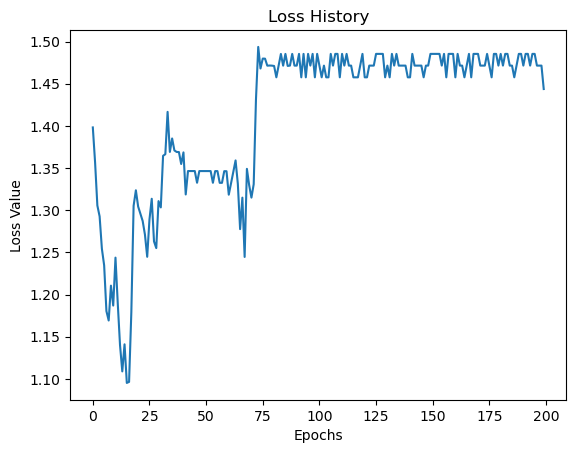

In [37]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/train_loss_history_three_layer_nn_without_dropout_adam.pdf", bbox_inches="tight")
plt.show()

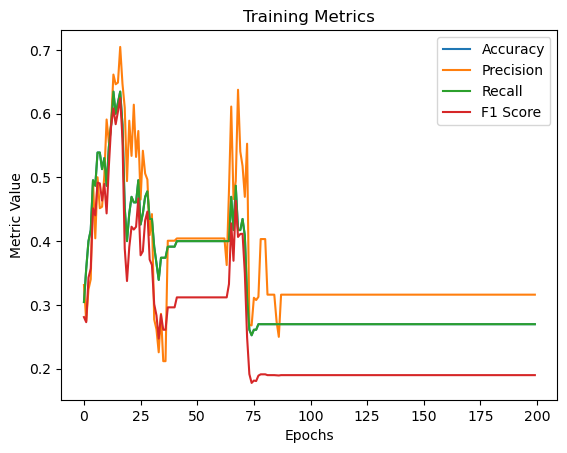

In [38]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_three_layer_nn_without_dropout_adam.pdf", bbox_inches="tight")
plt.show()

In [39]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.33039130434782604
Mean Training Precision: 0.3659636202931945
Mean Training Recall: 0.33039130434782604
Mean Training F1 Score: 0.25644883710121236


In [40]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [41]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [42]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3988407850265503
Testing Accuracy: 0.3448275862068966
Testing Precision: 0.7487684729064038
Testing Recall: 0.3448275862068966
Testing F1 Score: 0.4091954022988506
